In [71]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Many parts of this code were borrowed from or inspired by base code published in
Schimdt "Numerical Simulation of Optical Wave Propagation" 2010, 
and the open-source atmospheric wave optics Python package WavePy 
(most of which was translated from the Schmidt 2010 MATLAB code into Python):
    see 2016 paper: https://www.spiedigitallibrary.org/conference-proceedings-of-spie/9846/984603/
             WavePy-a-Python-package-for-wave-optics/10.1117/12.2225769.short?SSO=1
    or the actual code on GitHub: https://github.com/jpbos/WavePy    
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


import numpy as np
from numpy.fft import irfft2, rfft2, ifft2, fft2, fftshift
from math import pi, gamma, cos, sin
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as sig
import builtins as bt
from numpy import random
from matplotlib.colors import LogNorm
from scipy.special import gamma
from numpy.random import randn

In [72]:
"""""""""""""""""""""
Simulation parameters.
"""""""""""""""""""""

ngrid = 256 #number of gridpoints along 1 dimension
nscreen = 4 #number of screens
inner = 1e-3 #inner scale [m]
outer = 1e6 #outer scale [m]
lambd = 5e-6 #wavelength [m]
c = 3e8 #speed of light [m/s]
freq = c / lambd #frequency [Hz]
lambdmin = 1e-6 #minimum wavelength [m]
lambdmax = 3e-6 #minimum wavelength [m]
k = 2*pi/lambd #wavenumber [rad/m]
Cn2 = 1e-18 #structure parameter [m^-2/3]
dso = 5e4 #propagation distance from source to observer [m]
dxs = 4e-3 #sample length at source plane [m]
dxo = 4e-3 #sample lenth at observer plane [m]
scrnlength = ngrid*dxs #physical grid length along 1 dimension [m]
channels = 256 #number of frequency channels


In [73]:
"""""""""""""""""""""""""""
Set up propagation geometry.
"""""""""""""""""""""""""""

# Define a source plane
x = np.linspace(-ngrid//2, (ngrid//2)-1, ngrid) * dxs
y = np.linspace(-ngrid//2, (ngrid//2)-1, ngrid) * dxs
xs, ys = np.meshgrid(x, y)
rs = np.sqrt(xs ** 2 + ys ** 2)

# Define an observer plane
x = np.linspace(-ngrid//2, (ngrid//2)-1, ngrid) * dxo
y = np.linspace(-ngrid//2, (ngrid//2)-1, ngrid) * dxo
xo, yo = np.meshgrid(x, y)
ro = np.sqrt(xo ** 2 + yo ** 2)

# Set propagation geometry
# Define inter-screen distance
interscrn_dist = dso / (nscreen + 1)

# Make array of path intervals (dist. from one screen to another)
path_intervals = np.ones(nscreen + 1)*interscrn_dist

# Define number of planes in system (source + observer included)
nplanes = nscreen + 2

# Make array containing locations of each plane
path_locations = np.zeros(nplanes)
for path_step in range(0, nscreen + 1):
    path_locations[path_step+1] = path_locations[path_step] + path_intervals[path_step]

# Constrain to locations of each screen
screen_locations = path_locations[1:-1]

# Define fractional locations of each screen
frac_locations = path_locations / dso

# Define sampling at each screen
path_sampling = (dxo - dxs) * frac_locations + dxs

# Define inter-screen sampling ratio
interscrn_sampling_ratio = path_sampling[1:] / path_sampling[0:-1]

In [74]:
"""""""""""""""
Define sources.
"""""""""""""""

def point_source(r, dx):
    
    """""""""""""""""""""
    Flatte point source
    ...(see Schmidt 2010 
    eq. 6.84 on pg. 108)
    """""""""""""""""""""
    
    point = np.exp(-(r ** 2) / (10 * (dx ** 2))) \
        * np.cos(-(r ** 2) / (10 * (dx ** 2)))
    
    return point

def plane_source(N):
    
    """""""""""""""""""""
    Uniform plane wave.
    """""""""""""""""""""
    
    plane = np.ones([N, N])  

    return plane

In [75]:
"""""""""""""""""""""""
Generate phase screens.
"""""""""""""""""""""""

def GaussPhaseScreen(npoints=ngrid, NumScr=nscreen, uxmax=30., uymax=30., sigma = 0.05):
    
    """
    Set up Gaussian phase screen.
    """
    
    # Initial parameters
    L = 1e-3 #wavelength
    k = 2 * np.pi / L #wavenumber
    N_plane = 100 #number of superimposed plane waves, n.b. N should be O(10^3) to satisfy central limit thm
    #nrays = 200 #number of rays launched

    #np.random.seed(1734176512)

    # Dimensionless parameters defining how far to trace:
    xmin = 0. * k
    xmax = 200. * k
    ymin = -100. * k
    ymax = 100. * k

    # Store random variables for plane waves for consistency
    theta = np.random.uniform(0, 2*np.pi, N_plane)
    phi = np.random.uniform(0, 2*np.pi, N_plane)
    
    thetas = np.zeros((NumScr, N_plane))
    phis = np.zeros((NumScr, N_plane))
    for scr in range(NumScr):
        thetas[scr] = np.random.uniform(0,2*np.pi, N_plane)
        phis[scr] = np.random.uniform(0,2*np.pi, N_plane)
        
    # Construct u plane
    rx = np.linspace(-uxmax, uxmax, npoints)
    ry = np.linspace(-uymax, uymax, npoints)
    uvec = np.meshgrid(rx, ry)
    ux, uy = uvec
   
    screen = np.sqrt(2)*sigma*np.sqrt(1/N_plane)*bt.sum(np.cos(ux*np.sin(theta[j]) + \
                uy*np.cos(theta[j]) + phi[j]) for j in range(1, N_plane-2))
    
    return screen

def PowLawPhaseScreen(dsl, ngrid=ngrid, dxs=dxs, dso=dso, nscreen=nscreen, inner=inner, outer=outer, Cn2=Cn2, freq=freq, c=c, aniso=1, theta = np.pi/2):
    
    """
    Set up Kolmogorov phase screen.
    """
    
    def rF(dso=dso, dsl=dsl, freq=freq, c=c):
        
        """ 
        Define the fresnel scale.
        
        Parameters: 
            dso : distance from source to observer
            dsl : distance from source to lens
            f   : frequency
            dm  : dispersion measure (max electron 
                    density perturation in pc cm**-3)
        Returns:
            rF**2 : Square of the Fresnel scale rF
        """
        dlo = dso - dsl #distance from lens to observer
        rF = np.sqrt((dlo*c)/(2*np.pi*freq))
        return rF
    
    dxs = min(dxs, rF()/2)
    
    print('Frensel Scale (rF): ', rF())
    print('Targeted Sampling at Screen (dx): ', dxs)
    
    # Constants used in this code
    b = aniso
    c = 1.0
    thetar = (pi / 180.0) * theta
    
    # Set up parameters for Kolmogorov PSD
    alpha = 22.0
    norm_alpha = alpha / 6.0  # Normalized alpha value
    B_numerator = gamma(norm_alpha / 2.0)
    B_denomenator = 2.0 ** (2.0 - norm_alpha) * pi * norm_alpha * gamma(-norm_alpha / 2.0)
    cone = (2.0 * (8.0 / (norm_alpha - 2.0) * gamma(2.0 / (norm_alpha - 2.0))) ** ((norm_alpha - 2.0) / 2.0))
    B_factor = (2.0 * pi) ** (2.0 - norm_alpha) * (B_numerator / B_denomenator)
    a = gamma(norm_alpha - 1.0) * cos(norm_alpha * pi / 2.0) / (4.0 * pi ** 2.0)
    # inner-scale intertial range consistency parameter ???
    c_a = (gamma(0.5 * (5.0 - norm_alpha)) * a * 2.0 * pi / 3.0) ** (1.0 / (norm_alpha - 5.0))
    
    # Define inner and outer scales
    fme = c_a / inner  # Inner scale frequency(1/m)
    f0 = 1.0 / outer  # Outer scale frequency

    # Derive the frequency sampling at the current plane
    df = 1.0 / (ngrid * dxs)  # Frequency grid spacing(1/m)

    # The zero-frequency center of the phase screen
    cen = np.floor(ngrid / 2)

    # Create frequency sample grid
    fx = np.arange(-ngrid / 2.0, ngrid / 2.0) * df
    fx, fy = np.meshgrid(fx, -1 * fx)

    # Apply affine transform
    tx = fx * cos(thetar) + fy * sin(thetar)
    ty = -1.0 * fx * sin(thetar) + fy * cos(thetar)

    # Scalar frequency grid
    f = np.sqrt((tx ** 2.0) / (b ** 2.0) + (ty ** 2.0) / (c ** 2.0))
    
    # Define coherence diameter (or "Fried parameter") at screen
    r0scrn = (0.423 * ((k)**2) * Cn2 * (dso/nscreen))**(-3.0/5.0)

    # Sample Kolmogorov Turbulence Power Spectral Density (PSD)
    PSD_phi = cone*B_factor* (r0scrn**(2-norm_alpha)) * f**(-norm_alpha/2)
    PSD_phi[np.int(cen), np.int(cen)] = 0.0

    # Create a random field that is circular complex Guassian
    cn = (np.random.randn(ngrid, ngrid) + 1j * np.random.randn(ngrid, ngrid))

    # Filter by turbulence PSD
    cn = cn * np.sqrt(PSD_phi) * df

    # Inverse FFT
    phase_temp = np.fft.ifft2(np.fft.fftshift(cn)) * ((ngrid) ** 2)

    # Phase screens
    screen = np.real(phase_temp)
    
    return screen


In [76]:
def MakeSGB(N, r1):
    
    """
    Define a super gaussian boundary.
    """

    # Construction of Super Gaussian Boundary
    rad = r1 * (N);
    w = 0.55 * N
    sg = np.exp(- ((rad / w) ** 16.0))

    return sg


In [77]:
def mapToUprime(uvec, ax, ay, path_intervals, dsl, dso=dso, scrnlength=scrnlength, V=None):
    
    """ 
    Perform 2D raytracing (INCOMPLETE!!)
    
    Parameters:
        uvec : vector containing u-plane coordinates
        alp : alpha coefficient
        ax : characteristic length scale in x
        ay : characteristic length scale in y
    Returns:   
        [upx, upy] : array of coordinates in the u-plane that have been
                    mapped to coordiantes in the u'-plane
    """
    ux, uy = uvec
    
    scr = V
    V10 = np.gradient(V, axis = 0)
    V01 = np.gradient(V, axis = 1)

    dlo = dso - dsl #distance from lens to observer
    rF2 = (dlo*c)/(2*np.pi*freq)
    phi0 = np.mean(V)
    
    upx = ux + (rF2*1e4)*V10/(scrnlength**2)
    upy = uy + (rF2*1e4)*V01/(scrnlength**2)

    rays = np.array([upx, upy])

    return rays


In [78]:
"""""""""""""""""""""""
Generate phase screens.
"""""""""""""""""""""""

# initialize phase screen array
phz = np.zeros(shape=(ngrid, ngrid, nscreen))

for idxscr in range(0, nscreen, 1):

    dsl = path_locations[idxscr+1]
    
    # Generate a stack of Gaussian phase screens
    #phz[:, :, idxscr] = GaussPhaseScreen()
    
    # Generate a stack of Kolmogorov phase screens
    phz[:, :, idxscr] = PowLawPhaseScreen(dsl)

Frensel Scale (rF):  0.17841241161527713
Targeted Sampling at Screen (dx):  0.004
Frensel Scale (rF):  0.15450968080927585
Targeted Sampling at Screen (dx):  0.004
Frensel Scale (rF):  0.12615662610100803
Targeted Sampling at Screen (dx):  0.004
Frensel Scale (rF):  0.08920620580763856
Targeted Sampling at Screen (dx):  0.004


<ipython-input-75-f8013b8c374d>:116: RuntimeWarning: divide by zero encountered in power
  PSD_phi = cone*B_factor* (r0scrn**(2-norm_alpha)) * f**(-norm_alpha/2)


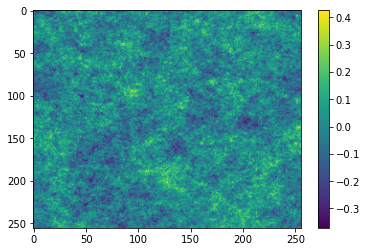

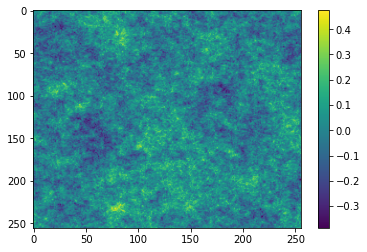

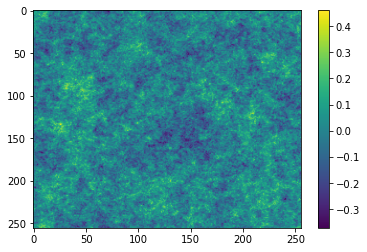

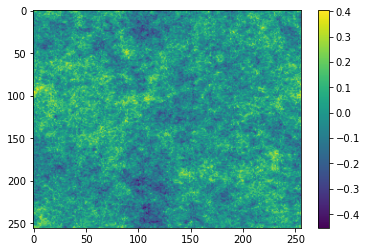

In [83]:
"""""""""""""""""""""
Plot phase screens.
"""""""""""""""""""""

for scr in range(0, nscreen):
    plt.imshow(phz[:, :, scr], aspect = 'auto')
    plt.colorbar()
    plt.show()

In [80]:
"""""""""""""""""""""
Perform 2D raytracing.
(INCOMPLETE!!)
"""""""""""""""""""""

uxmax, uymax = ngrid, ngrid #screen coordinates

# Construct u plane
rx = np.linspace(-uxmax, uxmax, ngrid)
ry = np.linspace(-uymax, uymax, ngrid)
uvec = np.meshgrid(rx, ry)
ux, uy = uvec
ax = ay = ngrid*dxs

raypropsteps = np.zeros((nscreen, 2, ngrid, ngrid)) #store ray wavefront at each screen

for scr in range(0, nscreen):

    if scr == 0:
        dsl = path_locations[scr+1]
        V = sig.savgol_filter(phz[:, :, scr], 41, 7)
        map_ = mapToUprime(uvec, ax, ay, path_intervals, dsl, V=V)#V=phz[:, :, scr])
        raypropsteps[scr] = map_

    else:
        dsl = path_locations[scr+1]
        V = sig.savgol_filter(phz[:, :, scr], 41, 7)
        map_ = mapToUprime(raypropsteps[scr-1], ax, ay, path_intervals, dsl, V=V)#V=phz[:, :, scr])
        raypropsteps[scr] = map_
        

In [81]:
"""""""""""""""
Generate source.
"""""""""""""""

source = plane_source(ngrid)

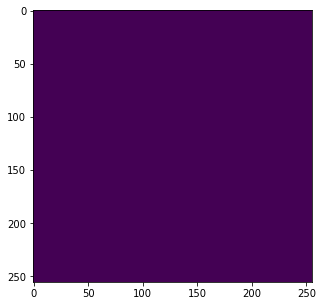

In [82]:
"""""""""""""""""
Plot source image.
"""""""""""""""""

fig = plt.figure(figsize = (5,5))
plt.imshow(source, aspect = 'auto')
plt.show()

In [84]:
def propagate(channels = channels, lambdmin = lambdmin, lambdmax = lambdmax):
    
    """
    Fresnel-Kirchoff wave propagation through multiple screens at multiple frequencies.
    """
    
    nlamb = np.linspace(lambdmin, lambdmax, channels) #store wavelength range
    wfout_ = np.zeros(shape=(ngrid, ngrid, nscreen+1)) #store wavefronts after each screen
    dyn_ = np.zeros(shape=(ngrid, channels, nscreen+1)) #store dynamic spectra after each screen
    secspec_ = np.zeros(shape=(channels, ngrid, nscreen+1)) #store secondary spectra after each screen
    
    # Propagation with the Fresnel-Kirchhoff Diffraction Integral

    for chan in np.arange(channels):

        # Generate super gaussian boundary
        sgb = MakeSGB(ngrid, rs)  

        a = int(ngrid / 2)

        nx, ny = np.meshgrid(range(-a, a), range(-a, a))

        # Initial Propagation from source plane to first screen location
        init_prop = np.exp(1j * (k / (2 * path_intervals[0])) * (rs ** 2) * (1 - interscrn_sampling_ratio[0]))

        # Incoming wavefront
        wfin = init_prop * source * np.exp(1j * np.exp(1j * phz[:, :, 0]))

        for scr in range(1, nscreen):

            wfin_spec = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(wfin)))

            # Set spatial frequencies at propagation plane
            deltaf = 1 / (ngrid * path_sampling[scr])
            fX = nx * deltaf
            fY = ny * deltaf
            fsq = fX ** 2 + fY ** 2

            # Quadratic Phase Factor
            quadphasefac = np.exp(-1j * np.pi * nlamb[chan] * path_intervals[scr] \
                                  * interscrn_sampling_ratio[scr] * fsq)

            wfin = np.fft.ifftshift(np.fft.ifft2( \
                np.fft.ifftshift(wfin_spec * quadphasefac)))

            #plt.imshow(phz[:, :, pcount - 1], aspect = 'auto')
            #plt.show()

            wfin = wfin * sgb * np.exp(1j * np.exp(1j * phz[:, :, scr - 1]))

            wfout_[:, :, scr] = np.abs(wfin * np.exp(1j * (k / (2 * path_intervals[scr])) \
                                                      * (ro ** 2) * (interscrn_sampling_ratio[-1])))**2

            dyn_[:, chan, scr] = wfout_[ngrid//2:ngrid//2+1, :, scr]
            #dyn_[:, chan, scr] = Uout_[200:201, :, scr]

            # Generate a secondary spectrum
            dynspec = np.transpose(dyn_[:, :, scr])
            hamm = np.hamming(len(dynspec[0]))
            dyn_tap = dynspec * hamm
            ss = fftshift(fft2(dyn_tap))
            ss = ss*np.conjugate(ss)
            ss_full = ss.real

            secspec_[:, :, scr] = ss_full
    
    return wfout_, dyn_, secspec_
    

In [85]:
"""""""""""""""""""""""""""""""""""""""""""""
Perform the progatation through all screens.
"""""""""""""""""""""""""""""""""""""""""""""

image, dyn, secspec = propagate()

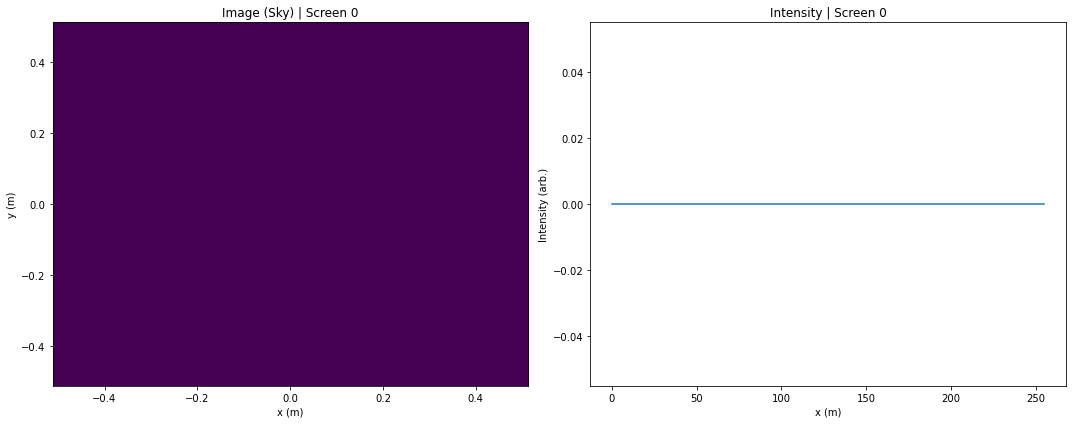

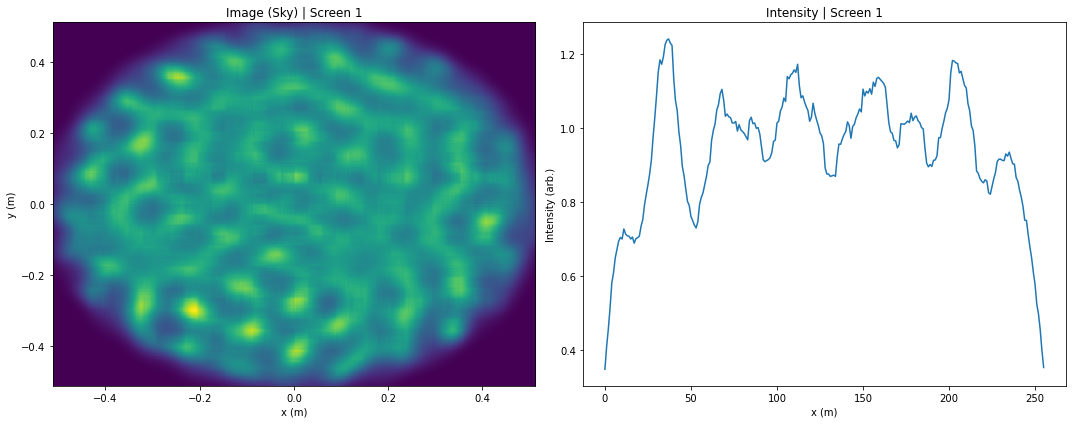

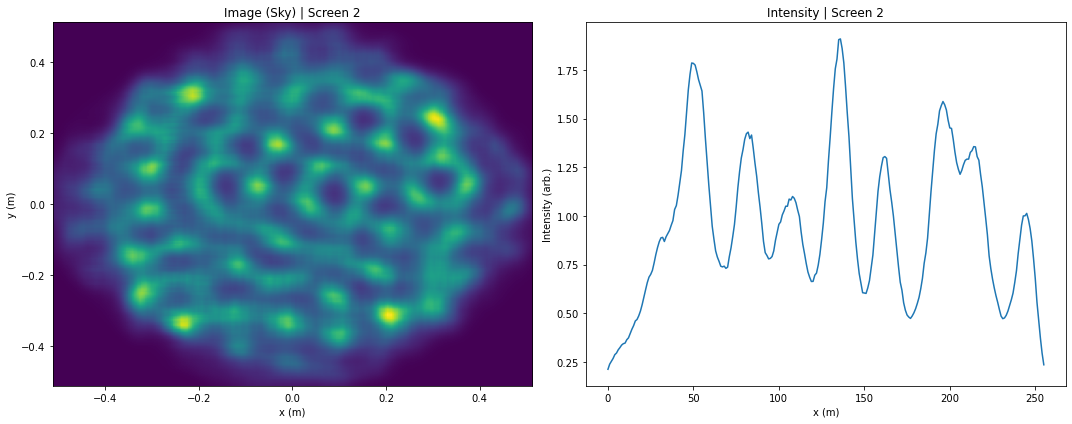

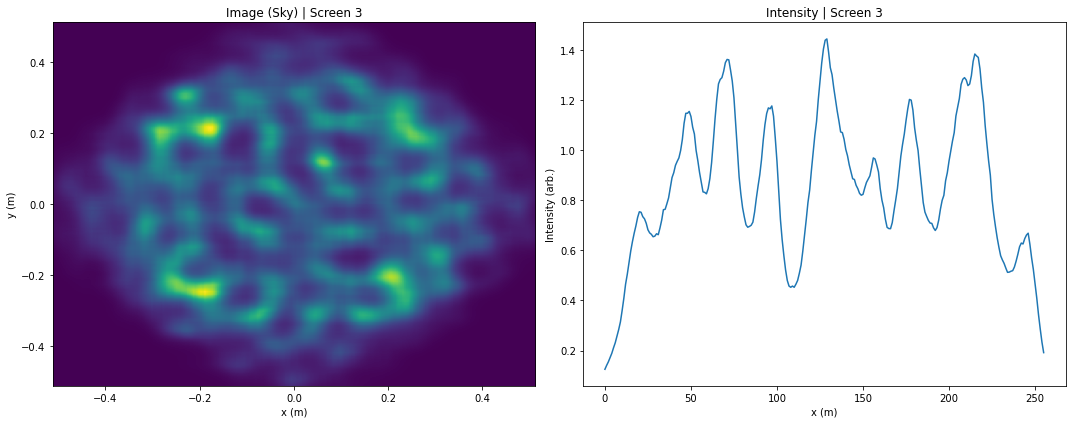

In [69]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Plot the image and intensity crosscut at each propagation step.
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

for i in range(nscreen):
    
    fig = plt.figure(figsize = (15, 6))
    
    ax1 = fig.add_subplot(121)
    
    sky = np.abs(image[:, :, i])**2
    plt.imshow(sky, aspect = 'auto', extent = \
               [-(ngrid*dxs)/2,(ngrid*dxs)/2,-(ngrid*dxs)/2,(ngrid*dxs)/2])#, norm = LogNorm())
    plt.title("Image (Sky) | Screen " + str(i))
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    
    # Plot raytracing - currently commented out, as it does not seem to give an accurate
    # representation of the scattered image
    #ax2 = fig.add_subplot(132)
    
    #xflat = np.ndarray.flatten(np.array(raypropsteps[i-1][0]))
    #yflat = np.ndarray.flatten(np.array(raypropsteps[i-1][1]))
    #plt.scatter(xflat, yflat, c = 'k', s = 0.02)
    #plt.title('Ray Tracing')
    
    ax2 = fig.add_subplot(122)
    
    x = np.linspace(-(ngrid*dxs)/2,(ngrid*dxs)/2, ngrid)
    plt.plot(sky[ngrid//2:ngrid//2+1, :].sum(0))
    plt.xlabel('x (m)')
    plt.ylabel('Intensity (arb.)')
    plt.title('Intensity | Screen ' + str(i))
    
    plt.tight_layout()
    plt.show()
    
    #fig.savefig('Image_' + 'Screen' + str(i) + '_Cn2' + str(Cn2) + '.png')

-5e-15
1.6666666666666666e-15


/Users/jakobfaber/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/jakobfaber/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/jakobfaber/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/jakobfaber/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


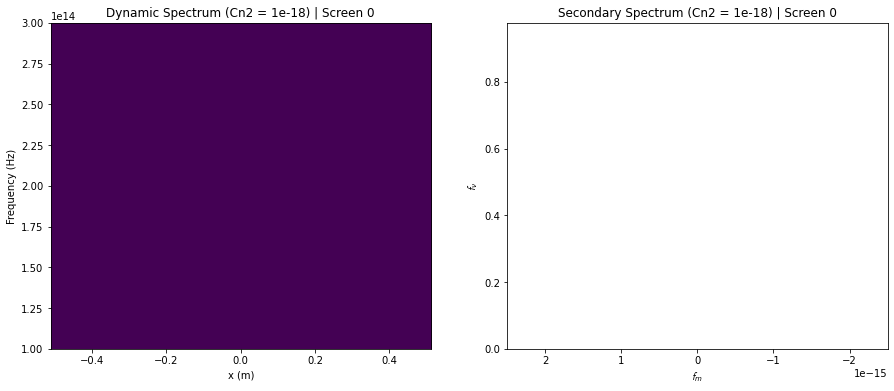

-5e-15
1.6666666666666666e-15


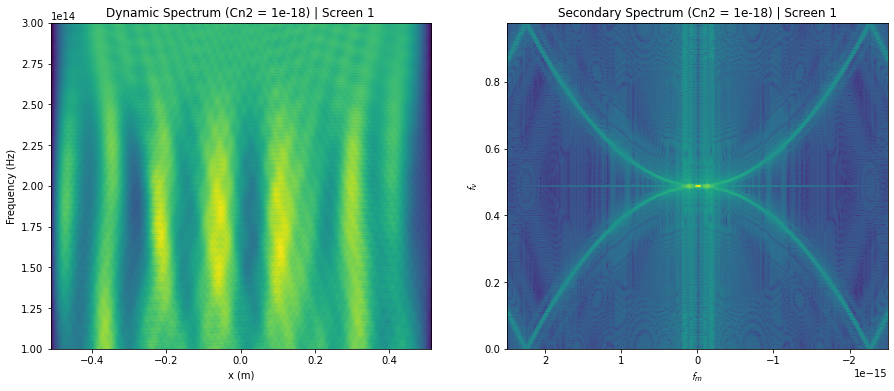

-5e-15
1.6666666666666666e-15


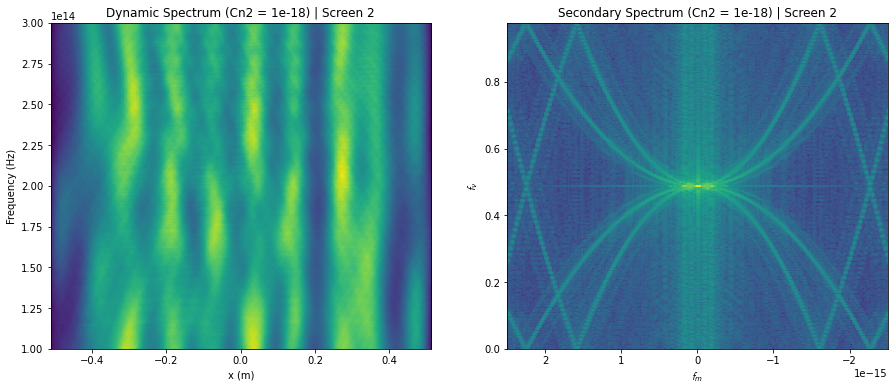

-5e-15
1.6666666666666666e-15


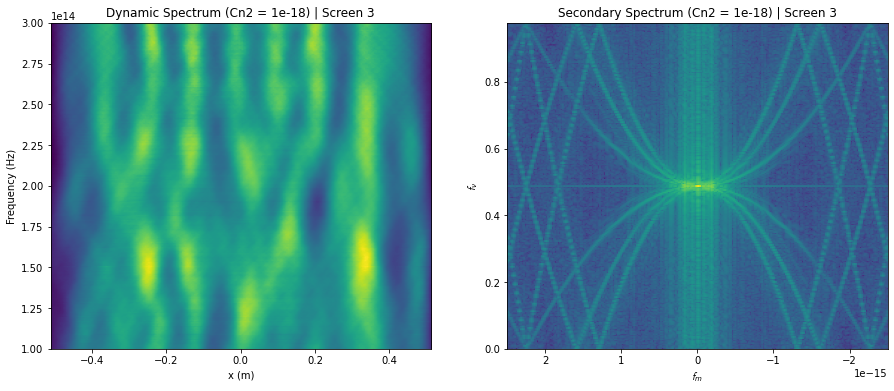

In [70]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Plot the dynamic and secondary spectra at each propagation step.
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

for i in range(nscreen):    
    fig = plt.figure(figsize  = (15, 6))
    ax1 = fig.add_subplot(121)
    plt.imshow(np.transpose(dyn[:, :, i]), aspect = 'auto', \
               extent = [-(ngrid*dxs)/2, (ngrid*dxs)/2, (3e8/lambdmax), (3e8/lambdmin)])
    plt.title('Dynamic Spectrum (Cn2 = ' + str(Cn2) + ')' + ' | Screen ' + str(i))
    plt.xlabel('x (m)')
    plt.ylabel('Frequency (Hz)')

    ax2 = fig.add_subplot(122)
    print(-(1/(3e8/lambdmax)/2))
    print((1/(3e8/lambdmin)/2))
    plt.imshow(secspec[:, :, i], aspect = 'auto', norm = LogNorm(), extent = [-(1/(3e8/lambdmax - 3e8/lambdmin)/2), (1/(3e8/lambdmax - 3e8/lambdmin)/2), 0, 1/(ngrid*dxs)])
    plt.ylabel(r'$\mathcal{f}_{\nu}$')
    plt.xlabel(r'$\mathcal{f}_{m}$')
    plt.title('Secondary Spectrum (Cn2 = ' + str(Cn2) + ')' + ' | Screen ' + str(i))
    plt.show()
    #fig.savefig('DynSec_' + 'Screen' + str(i) + '_Cn2' + str(Cn2) + '.png')

#### s_i = []
for i in range(nscreen):    
    temp_s = (np.abs(image[:, :, i]) ** 2)
    temp_s = temp_s.ravel()[np.flatnonzero(temp_s)]
    s_i.append((np.mean(temp_s ** 2) / (np.mean(temp_s) ** 2)) - 1)

plt.plot(s_i)

-----------------------------------------------------------------------------------------------------------------

# Additional phase screen functions

In [ ]:
#Alternate inputs (trying to get to pulsar-relevant scales)

#ngrid = 256 #gridpoints
#nscreen = 4 #number of screens
#inner = 1e-34*s #inner scale [m]
#outer = 1e3*s #outer scale [m]
#lambd = 1e-6*s #wavelength [m]
#lambdmin = 1e-4*s
#lambdmax = 1.005e-4*s
#k = 2*pi/lambd #wavenumber
#alpha = 22.
#Cn2 = 1e-25*s #structure constant
#dso = 3e19*s #propagation distance (along L.O.S.) [m]
#dxs = 5e-7*s #sample at source plane [m]
#dxo = 5e-7*s #sample at observer plane [m]
#length = ngrid*dxs #physical grid size in x/y [m]
#rF = np.sqrt(lambd*dso / 2*np.pi) #fresnel scale
#aniso = 1.
#channels = 256

In [738]:
#ngrid = 256 #gridpoints
#nscreen = 4 #number of screens
#inner = 1e-3*s #inner scale [m]
#outer = 1e9*s #outer scale [m]
#lambd = 4.*s #wavelength [m]
#lambdmin = 1e-1*s
#lambdmax = 2e-1*s
#k = 2*pi/lambd #wavenumber
#alpha = 8./3.
#mb2 = 20.
#Cn2 = 1e-14*s #structure constant
#dso = 3e9*s #propagation distance (along L.O.S.) [m]
#dxs = 5*s #sample at source plane [m]
#dxo = 5*s #sample at observer plane [m]
#length = ngrid*dxs #physical grid size in x/y [m]
#rF = np.sqrt(lambd*dso / 2*np.pi) #fresnel scale
#aniso = 1.
#channels = 128
#
#psi = 0.
#ar = 1.

#print(ngrid*dxs)

In [739]:
def set_constants(nx, ny, dx, dy, rf, alpha, mb2, gamma):

    ns = 1
    lenx = nx*dx
    leny = ny*dy
    ffconx = (2.0/(ns*lenx*lenx))*(np.pi*rf)**2
    ffcony = (2.0/(ns*leny*leny))*(np.pi*rf)**2
    dqx = 2*np.pi/lenx
    dqy = 2*np.pi/leny
    # dqx2 = dqx*dqx
    # dqy2 = dqy*dqy
    a2 = alpha*0.5
    # spow = (1.0+a2)*0.5
    # ap1 = alpha+1.0
    # ap2 = alpha+2.0
    aa = 1.0+a2
    ab = 1.0-a2
    cdrf = 2.0**(alpha)*np.cos(alpha*np.pi*0.25)\
        * gamma(aa)/mb2
    s0 = rf*cdrf**(1.0/alpha)

    cmb2 = alpha*mb2 / (4*np.pi * gamma(ab)*np.cos(alpha * np.pi*0.25)*ns)
    consp = cmb2*dqx*dqy/(rf**alpha)
    scnorm = 1.0/(nx*ny)

    # ffconlx = ffconx*0.5
    # ffconly = ffcony*0.5
    sref = rf**2/s0
    
    return a2, cdrf, s0, cmb2, consp, scnorm, ffconx, ffcony, sref

In [740]:
def swdsp(psi, ar, consp, inner, kx=0, ky=0):
    cs = np.cos(psi*np.pi/180)
    sn = np.sin(psi*np.pi/180)
    r = ar
    con = np.sqrt(consp)
    alf = -(alpha+2)/4
    # anisotropy parameters
    a = (cs**2)/r + r*sn**2
    b = r*cs**2 + sn**2/r
    c = 2*cs*sn*(1/r-r)
    q2 = a * np.power(kx, 2) + b * np.power(ky, 2) + c*np.multiply(kx, ky)
    # isotropic inner scale
    out = con*np.multiply(np.power(q2, alf),
                          np.exp(-(np.add(np.power(kx, 2),
                                          np.power(ky, 2))) *
                                                 inner**2/2))
    return out

In [741]:
def scr_gen(nx, ny, dx, dy, psi, ar, consp, inner):
    
    """
    Get phase screen in x and y
    """
    
    #Seed Random Number Generator
    #if seed:    
    #    np.random.seed(seed)

    nx2 = int(nx/2 + 1)
    ny2 = int(ny/2 + 1)

    #Initialize array
    w = np.zeros([nx, ny])  
    dqx = 2*np.pi/(dx*nx)
    dqy = 2*np.pi/(dy*ny)

    #Screen Weights
    # first do ky=0 line
    k = np.arange(2, nx2+1)
    w[k-1, 0] = swdsp(psi, ar, consp, inner, kx=(k-1)*dqx, ky=0)
    w[nx+1-k, 0] = w[k, 0]
    # then do kx=0 line
    ll = np.arange(2, ny2+1)
    w[0, ll-1] = swdsp(psi, ar, consp, inner, kx=0, ky=(ll-1)*dqy)
    w[0, ny+1-ll] = w[0, ll-1]
    # now do the rest of the field
    kp = np.arange(2, nx2+1)
    k = np.arange((nx2+1), nx+1)
    km = -(nx-k+1)
    for il in range(2, ny2+1):
        w[kp-1, il-1] = swdsp(psi, ar, consp, inner, kx=(kp-1)*dqx, ky=(il-1)*dqy)
        w[k-1, il-1] = swdsp(psi, ar, consp, inner, kx=km*dqx, ky=(il-1)*dqy)
        w[nx+1-kp, ny+1-il] = w[kp-1, il-1]
        w[nx+1-k, ny+1-il] = w[k-1, il-1]

    #Generate Complex Gaussian Array
    xyp = np.multiply(w, np.add(randn(nx, ny),
                                1j*randn(nx, ny)))

    xyp = np.real(fft2(xyp))
    
    return xyp

In [742]:
a2, cdrf, s0, cmb2, consp, scnorm, ffconx, ffcony, sref = set_constants(ngrid, ngrid, dxs, dxs, rF, alpha, mb2, gamma)
scrn = scr_gen(ngrid, ngrid, dxs, dxs, psi, ar, consp, inner)

<ipython-input-739-bc41f50acd7a>:20: RuntimeWarning: invalid value encountered in double_scalars
  s0 = rf*cdrf**(1.0/alpha)
